In order to easily load the results, run the following command line in the same directory as this notebook:

```shell
git clone --depth 1 https://github.com/mlperf/training_results_v0.7
```

In [2]:
import glob
import json
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

class ResultsParser(object):
    def __init__(self, directory):
        self.directory = directory
        self.mllog = {}
        self.read_results_file()
    def read_results_file(self):
        files = glob.glob(self.directory+"/*.txt")
        for file_path in files:
            lines = [line.rstrip('\n') for line in open(file_path)]
            for line in lines:
                self.result_mllog = defaultdict(list)
                if ":::MLLOG" in line:
                    mllog_checkpoint = json.loads(line.split(":::MLLOG")[1])
                    self.mllog[mllog_checkpoint["key"]] = int(mllog_checkpoint["time_ms"])
            # lazy, do just take one results file and be done
            break
    def get_full_results(self):
        return self.mllog
    def calculate_duration_seconds(self, start_ms, stop_ms, round_to=1):
        return round((stop_ms-start_ms)/1000, round_to)
    def get_init_duration(self):
        init_start = self.mllog["init_start"]
        init_stop = self.mllog["init_stop"]
        return self.calculate_duration_seconds(init_start, init_stop)
    def get_train_run_duration(self):
        run_start = self.mllog["run_start"]
        run_stop = self.mllog["run_stop"]
        return self.calculate_duration_seconds(run_start, run_stop)
    def get_full_duration(self):
        return self.get_init_duration() + self.get_train_run_duration()
    def get_report(self):
        print("Time Taken (seconds)")
        print("====================")
        print(" Init:", self.get_init_duration())
        print("  Run:", self.get_train_run_duration())
        print("Total:", self.get_full_duration())
        print("====================")
        print("Results dir:")
        print(self.directory)

## BERT

NVIDIA A100 vs Google TPU

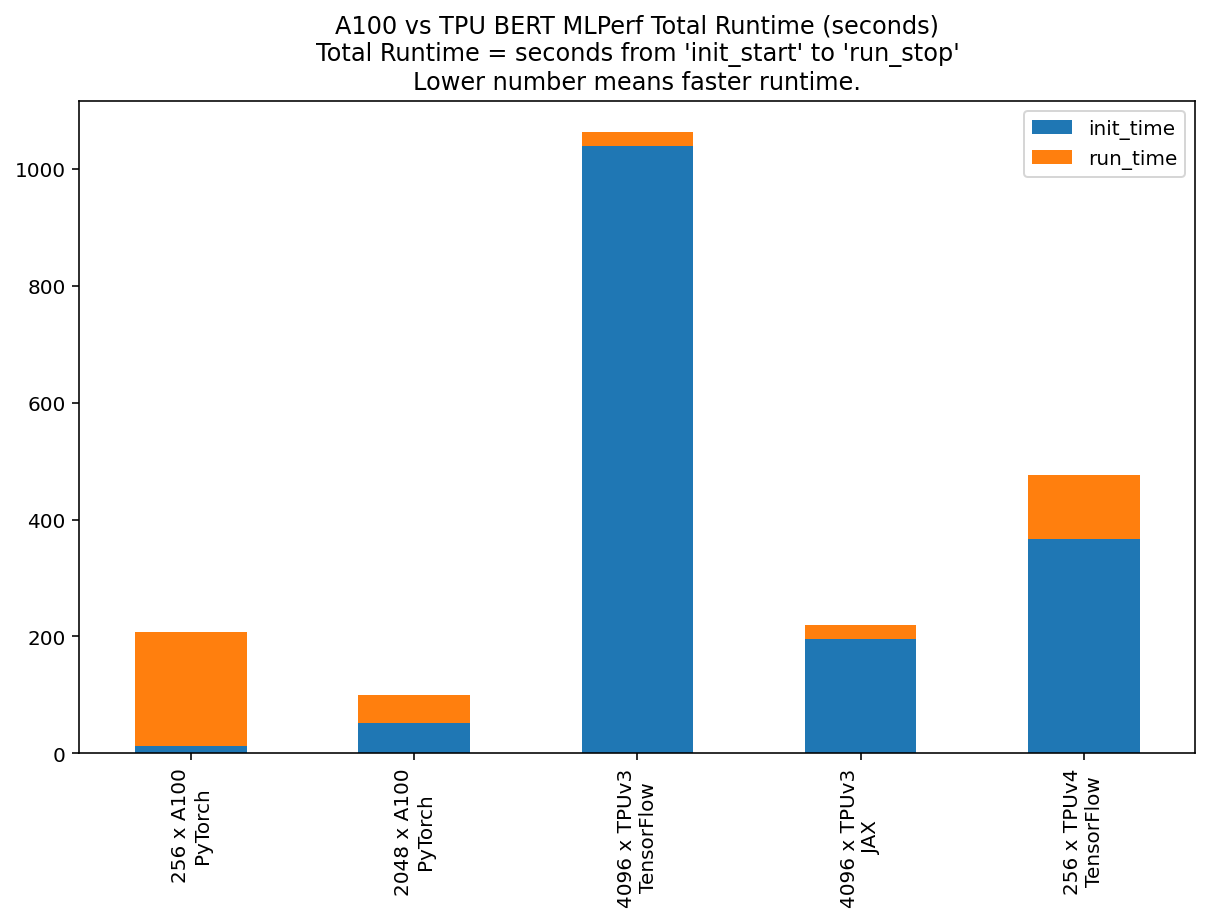

In [4]:
nvidia_fastest_bert = "./training_results_v0.7/NVIDIA/results/dgxa100_n256_ngc20.06_pytorch/bert"
nvidia_results = ResultsParser(nvidia_fastest_bert)

nvidia_low_node_bert = "./training_results_v0.7/NVIDIA/results/dgxa100_n32_ngc20.06_pytorch/bert"
nvidia_low_node_results = ResultsParser(nvidia_low_node_bert)

google_fastest_bert = "./training_results_v0.7/Google/results/tpu-v3-8192-TF/bert"
google_results = ResultsParser(google_fastest_bert)

google_fastest_bert_jax = "./training_results_v0.7/Google/results/tpu-v3-8192-JAX/bert"
google_results_jax = ResultsParser(google_fastest_bert_jax)

google_tpuv4_bert = "./training_results_v0.7/Google/results/tpu-v4-512-TF/bert"
google_tpuv4_results = ResultsParser(google_tpuv4_bert)

plotdata = pd.DataFrame({
    "init_time": [nvidia_low_node_results.get_init_duration(),
                  nvidia_results.get_init_duration(),
                  google_results.get_init_duration(),
                  google_results_jax.get_init_duration(),
                  google_tpuv4_results.get_init_duration()],
    "run_time": [nvidia_low_node_results.get_train_run_duration(),
                 nvidia_results.get_train_run_duration(),
                 google_results.get_train_run_duration(),
                 google_results_jax.get_train_run_duration(),
                 google_tpuv4_results.get_train_run_duration()],
    }, 
    index=["256 x A100\nPyTorch", "2048 x A100\nPyTorch", "4096 x TPUv3\nTensorFlow", "4096 x TPUv3\nJAX", "256 x TPUv4\nTensorFlow"]
)
plot_title = "A100 vs TPU BERT MLPerf Total Runtime (seconds)\n" + \
             "Total Runtime = seconds from 'init_start' to 'run_stop'\n" + \
             "Lower number means faster runtime."
plotdata.plot(kind="bar", title=plot_title, stacked=True, figsize=(10,6))
plt.show()

## Transformer (translation, non-recurrent benchmark)

NVIDIA A100 vs Google TPU

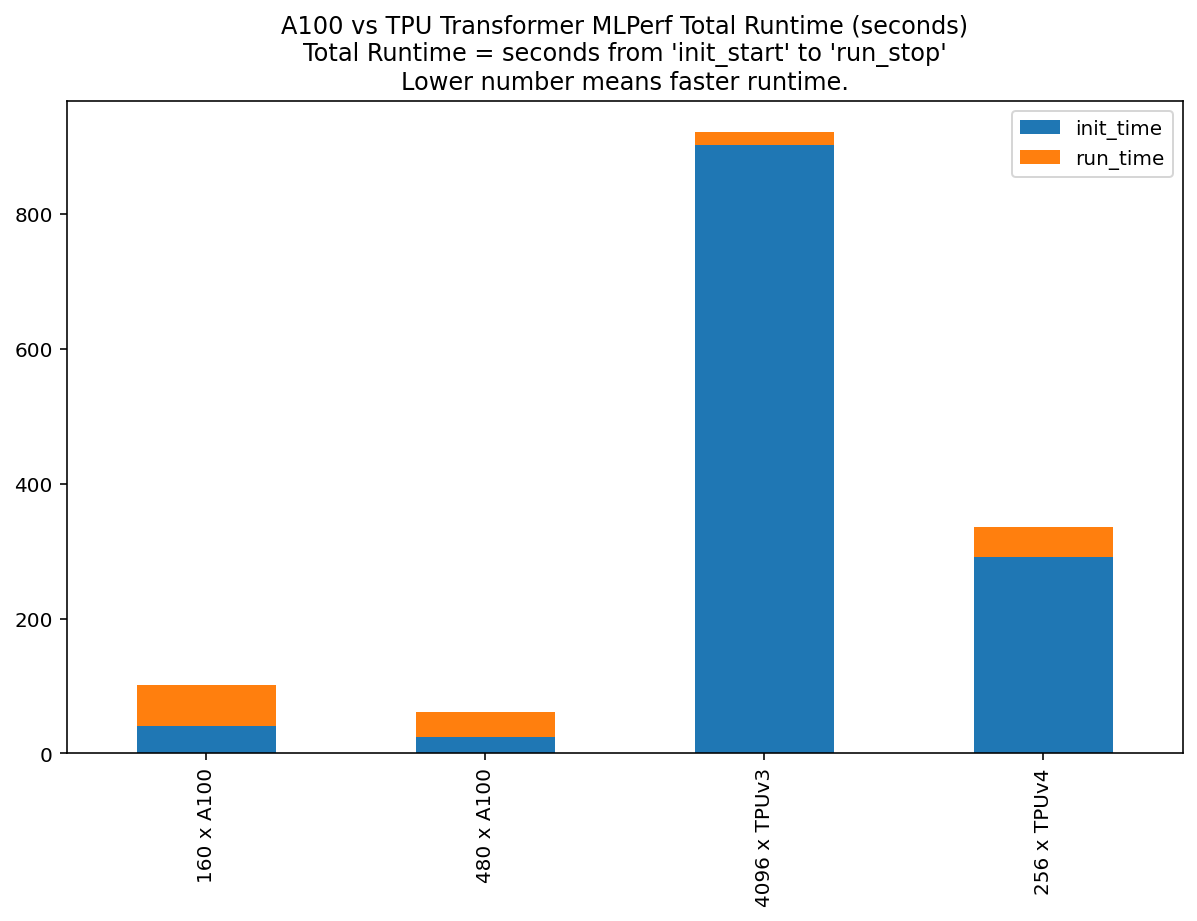

In [3]:
nvidia_fastest_tfmr = "./training_results_v0.7/NVIDIA/results/dgxa100_n60_ngc20.06_pytorch/transformer"
nvidia_results = ResultsParser(nvidia_fastest_tfmr)

nvidia_low_node_tfmr = "./training_results_v0.7/NVIDIA/results/dgxa100_n20_ngc20.06_pytorch/transformer"
nvidia_low_node_results = ResultsParser(nvidia_low_node_tfmr)

google_fastest_tfmr = "./training_results_v0.7/Google/results/tpu-v3-8192-TF/transformer"
google_results = ResultsParser(google_fastest_tfmr)

google_tpuv4_tfmr = "./training_results_v0.7/Google/results/tpu-v4-512-TF/transformer"
google_tpuv4_results = ResultsParser(google_tpuv4_tfmr)

plotdata = pd.DataFrame({
    "init_time": [nvidia_low_node_results.get_init_duration(),
                  nvidia_results.get_init_duration(),
                  google_results.get_init_duration(),
                  google_tpuv4_results.get_init_duration()],
    "run_time": [nvidia_low_node_results.get_train_run_duration(),
                 nvidia_results.get_train_run_duration(),
                 google_results.get_train_run_duration(),
                 google_tpuv4_results.get_train_run_duration()],
    }, 
    index=["160 x A100", "480 x A100", "4096 x TPUv3", "256 x TPUv4"]
)
plot_title = "A100 vs TPU Transformer MLPerf Total Runtime (seconds)\n" + \
             "Total Runtime = seconds from 'init_start' to 'run_stop'\n" + \
             "Lower number means faster runtime."
plotdata.plot(kind="bar", title=plot_title, stacked=True, figsize=(10,6))
plt.show()